# Simulating LD matrices for gene set association analysis with gene-e

See https://github.com/pystatgen/sgkit/issues/692

In [1]:
! wget -q -O - --header Metadata-Flavor:Google metadata/computeMetadata/v1/instance/machine-type

projects/452178172058/machineTypes/e2-standard-32

In [2]:
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.sparse import csc_matrix, diags

from sklearn.linear_model import ElasticNet, LinearRegression

In [3]:
def random_banded_ld_matrix(n, d):
    """Create a banded square n x n symmetric CSC matrix, where d diagnonals above and below
    the main diagonal have random values in [-1, 1], and where the main diagonal contains ones."""
    band = np.random.uniform(-1, 1, (d, n))
    diagonals = np.empty((2 * d + 1, n), dtype=band.dtype)
    diagonals[0] = 1
    diagonals[1:d+1] = band
    diagonals[d+1:2*d+1] = band
    offsets = np.concatenate((np.arange(d+1), np.arange(-1, -d-1, step=-1)))
    m = diags(diagonals, offsets)
    m = m.tocsc()
    return m

Example 8x8 matrix with d=2

In [4]:
X = random_banded_ld_matrix(8, 2)
X.todense()

matrix([[ 1.00000000e+00, -1.46881806e-01,  3.71338084e-01,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-1.46881806e-01,  1.00000000e+00, -5.84151888e-01,
         -5.47049948e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 3.71338084e-01, -5.84151888e-01,  1.00000000e+00,
         -9.99903069e-01,  3.03512712e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -5.47049948e-01, -9.99903069e-01,
          1.00000000e+00,  7.78814566e-01, -6.07053118e-01,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  3.03512712e-01,
          7.78814566e-01,  1.00000000e+00,  6.16291015e-04,
          2.01166869e-01,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -6.07053118e-01,  6.16291015e-04,  1.00000000e+00,
         -9.07153265e-01,  9.71470247e-01],
        [ 0.0000

This shows the banding structure a bit more clearly:

In [5]:
X.todense() != 0.0

matrix([[ True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False],
        [False,  True,  True,  True,  True,  True, False, False],
        [False, False,  True,  True,  True,  True,  True, False],
        [False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True]])

Let's simulate some LD matrices of size _n_ x _n_. The sparsity used is based on ["50 variants in a 100 Kbp window"](https://github.com/pystatgen/sgkit/issues/692#issuecomment-964005351), i.e. 50/100,000 = 0.0005.

Note that a real LD matrix will not have a dense band like this, it will be sparse across a wider band. But the number of entries will be the same as the simulations here, so hopefully the results are broadly representative.

In [6]:
def simulate_matrices(n, sparsity=0.0005):
    d = max(1, int(n * sparsity))
    X = random_banded_ld_matrix(n, d)
    b = np.random.normal(size=n) * np.sqrt(n)
    y = b.T @ X + np.random.normal(size=n) # add some random noise
    return X, y

This shows the top corner of such a matrix:

In [7]:
simulate_matrices(1000)[0].todense()[:5,:5]

matrix([[1.        , 0.29885411, 0.        , 0.        , 0.        ],
        [0.29885411, 1.        , 0.32338819, 0.        , 0.        ],
        [0.        , 0.32338819, 1.        , 0.46002736, 0.        ],
        [0.        , 0.        , 0.46002736, 1.        , 0.43331556],
        [0.        , 0.        , 0.        , 0.43331556, 1.        ]])

Time how long it takes to simulate different size LD matrices, and also how long it takes to run a regression on each of them.

In [8]:
def sparse_nbytes(m):
    return m.data.nbytes + m.indptr.nbytes + m.indices.nbytes

def sizeof_fmt(num, suffix="B"):
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Yi{suffix}"

In [9]:
def run_regression(X, y):
    regr = ElasticNet(alpha=1, l1_ratio=0.5, fit_intercept=False, random_state=0)
    regr.fit(X=X, y=y)
    return regr

In [10]:
d = []
for n in (10000, 20000, 50000, 100000, 200000, 500000, 1000000):
    t0 = time.time()
    X, y = simulate_matrices(n)
    t1 = time.time()
    regr = run_regression(X, y)
    t2 = time.time()
    t_cons = t1 - t0
    t_regr = t2 - t1
    non_zero_coeffs = np.sum(regr.coef_ != 0)
    
    print(f"{n}, {sizeof_fmt(sparse_nbytes(X))}, {regr.n_iter_}, {t_cons:.2f}s, {t_regr:.2f}s, {non_zero_coeffs}")
    d.append(dict(n=n, bytes=sparse_nbytes(X), n_iter=regr.n_iter_, t_cons=t_cons, t_regr=t_regr, non_zero_coeffs=non_zero_coeffs))
df = pd.DataFrame(d)
df

10000, 1.3MiB, 1, 0.01s, 0.01s, 0
20000, 4.9MiB, 1, 0.03s, 0.00s, 0
50000, 29.4MiB, 2, 0.10s, 0.03s, 4
100000, 115.9MiB, 3, 0.35s, 0.11s, 164
200000, 460.7MiB, 3, 1.20s, 0.39s, 4100
500000, 2.8GiB, 3, 7.47s, 2.59s, 68554
1000000, 11.2GiB, 3, 38.14s, 11.08s, 290350


,n,bytes,n_iter,t_cons,t_regr,non_zero_coeffs
0,10000,1359644,1,0.006450,0.010694,0
1,20000,5118684,1,0.025132,0.004715,0
2,50000,30792204,2,0.098272,0.026275,4
3,100000,121569404,3,0.349929,0.107214,164
4,200000,483078804,3,1.202346,0.391462,4100
5,500000,3007247004,3,7.469673,2.587718,68554
6,1000000,12012994004,3,38.135117,11.081271,290350


The time grows quadratically, as might be expected since the number of nonzero entries in the LD matrix is _n_ x _n_ x _sparsity_.

In [11]:
reg = LinearRegression()
reg.fit(np.log(df[['n']]), np.log(df['t_regr']))
reg.coef_

array([1.67281962])

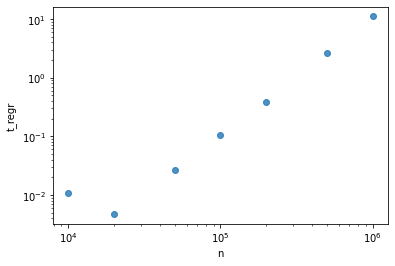

In [12]:
splot = sns.regplot(x="n", y="t_regr", data=df, fit_reg=False)
splot.set(xscale="log", yscale="log");

So 1M variants with the sparsity shown above is feasible.

For 7M variants (number of variants in 1000 genomes, chr2), the memory needed would be:


In [13]:
reg = LinearRegression()
reg.fit(np.log(df[['n']]), np.log(df['bytes']))
mem = np.exp(reg.predict(np.log([[7000000]]))).item()
sizeof_fmt(mem)

/home/tom/miniconda/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


'512.1GiB'

And the regression would take about:

In [14]:
reg = LinearRegression()
reg.fit(np.log(df[['n']]), np.log(df['t_regr']))
t = np.exp(reg.predict(np.log([[7000000]]))).item()
f"{t:.0f}s"

/home/tom/miniconda/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


'181s'

Of course, datasets with more samples will have more variants (although the sparsity will presumably not change), so the memory and time will grow accordingly.